In [1]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import pennylane as qml
import torch 

# ==============================
# User defined 
# ==============================
import plot_data as pt
import torch_optimizer as tr_opt

In [2]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=3)

# Define Hamiltonian for quantum computations
# H = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])

# H = qml.Hamiltonian(coeffs=[-0.5], observables=[qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2)])
# H_1 = qml.Hamiltonian(coeffs=[-0.5, -0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2)])

H = qml.Hamiltonian(
    coeffs=[-0.5, -1], 
    observables=[
        qml.PauliZ(0) @ qml.PauliZ(1) @ qml.Identity(2), 
        qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2)
    ]
)

H_1 = qml.Hamiltonian(
    coeffs=[-0.5, -0.5, -0.5], 
    observables=[qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2)]
)

## New Hamiltonian

#### Entangler Hamiltonian

$$
H = -0.5 \, Z_0 \otimes Z_1 \otimes I_{2} 
-0.5 \, I_{0} \otimes Z_1 \otimes Z_2
$$


$$
where,
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

#### Phase Accumulator Hamiltonian


$$
H_{1} = -0.5 \cdot Z_0 - 0.5 \cdot Z_1 - 0.5 \cdot Z_2 
$$



$$

$$


$$
where,
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

In [3]:
# Global Parameters
Tau_global = torch.tensor(0, dtype=torch.float, requires_grad=False)   # Dephase tau
Gamma_ps_global = torch.tensor(0, dtype=torch.float, requires_grad=False)
Paras_global = torch.tensor([0, 0, 0, 0, 0, 0], dtype=torch.float, requires_grad=True)
Phi_global = torch.tensor(0, dtype=torch.float, requires_grad=True)

def Dephase_factor(tau):
    """ 
    Calculate the dephasing factor for a given dephasing time tau.

    Args:
        tau (torch.Tensor): Dephasing time.

    Returns:
        torch.Tensor: Dephasing factor.
    """  
    return 1 - torch.exp(-2 * tau)

$$
Let, e^{-t/T_2} = e^{-\tau} \\[1em]

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}
$$

$$
\\[1em]
Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [4]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def circuit(phi):
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    phi_z1 = Paras_global[1]
    phi_z2 = Paras_global[2]
    phi_z3 = Paras_global[3]
    tau_1 = Paras_global[4]
    tau_2 = Paras_global[5]
    
    gamma_dephase = Dephase_factor(Tau_global)
    
    # Stage_1: RY for pi/2
    qml.RY(torch.pi/2, wires=0)
    qml.RY(torch.pi/2, wires=1)
    qml.RY(torch.pi/2, wires=2)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(H, tau_1, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1)    
    qml.PhaseDamping(gamma_dephase, wires = 2)    
    
    qml.RX(theta_x, wires = 0)    
    qml.RX(theta_x, wires = 1)    
    qml.RX(theta_x, wires = 2)    

    qml.RY(-torch.pi/2, wires = 0)    
    qml.RY(-torch.pi/2, wires = 1)   
    qml.RY(-torch.pi/2, wires = 2)   

    qml.ApproxTimeEvolution(H, tau_2, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    qml.PhaseDamping(gamma_dephase, wires = 2) 
    
    qml.RY(torch.pi/2, wires = 0)    
    qml.RY(torch.pi/2, wires = 1) 
    qml.RY(torch.pi/2, wires = 2) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(H_1, phi, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    qml.PhaseDamping(gamma_dephase, wires = 2) 
    
    qml.RZ(phi_z1, wires=0)
    qml.RZ(phi_z2, wires=1)
    qml.RZ(phi_z3, wires=2)
    
    qml.RX(torch.pi/(2), wires=0)
    qml.RX(torch.pi/(2), wires=1)
    qml.RX(torch.pi/(2), wires=2)
    
    # return qml.state()
    return qml.density_matrix(wires = [0, 1, 2])

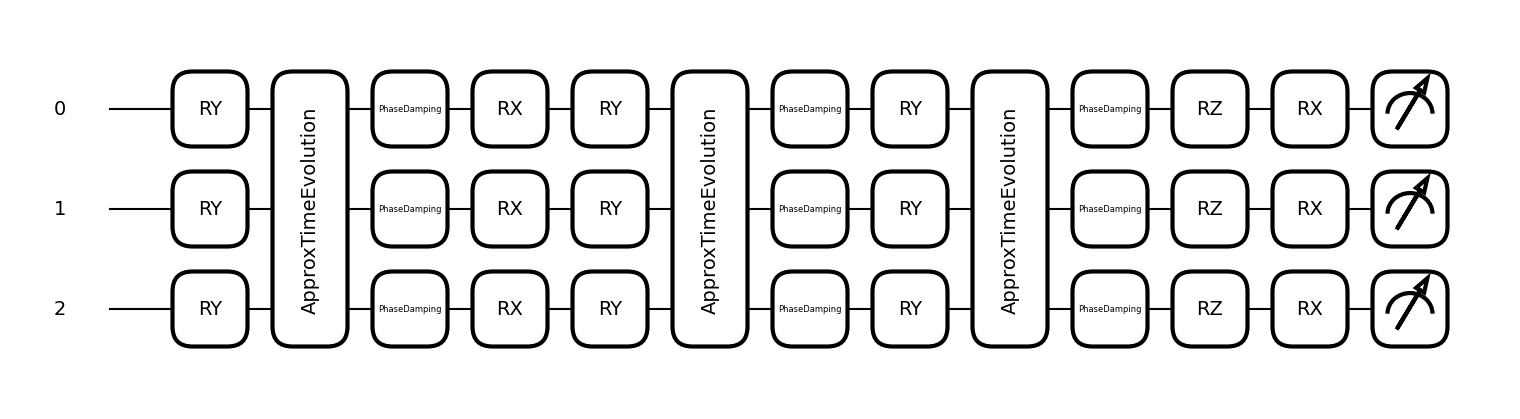

In [5]:
fig, ax = qml.draw_mpl(circuit)(np.pi)

In [6]:
@qml.qnode(dev, interface = 'torch', diff_method = 'backprop')
def Post_selection(phi):

    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)
        
    # Kraus operator for 8*8 matrix
    K = torch.tensor([
        [torch.sqrt(1 - Gamma_ps_global), 0], 
        [0, 1]
    ], dtype=torch.complex128)
    
    Numerator = torch.kron(K, torch.kron(K, K)) @ get_density_matrix @ torch.kron(K, torch.kron(K, K)).conj().T
    Denominator = torch.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1, 2])
    
    return qml.density_matrix(wires = [0, 1, 2])  

#### Expand for 3-qubit 

$$ 
K =  \begin{bmatrix}
\sqrt{1-\gamma_{ps}} & 0 \\
0 & 1 
\end{bmatrix}  
$$


$$
\rho_{ps} = 
\frac{(K \otimes(K \otimes K)) \rho (K \otimes(K \otimes K))^{\dagger}}
% (K^{\dagger} \otimes I ^{\dagger})}

{Tr[(K \otimes(K \otimes K)) \rho (K \otimes(K \otimes K))^{\dagger}]}
$$

In [7]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Set the global dephasing rate and post-selection rate for the circuit.

    Args:
        desired_tau_dephase (float): Desired dephasing rate tau.
        desired_gamma_post_selection (float): Desired post-selection rate gamma.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = torch.tensor(desired_tau_dephase)
    Gamma_ps_global = torch.tensor([desired_gamma_post_selection])

In [8]:
def cost_function(paras):
    """ 
    Compute the cost using classical Fisher information for the given parameters.

    Args:
        paras (torch.Tensor): Parameters for quantum gates.

    Returns:
        torch.Tensor: Computed cost.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)
    
    return -CFI

In [9]:
def sweep_cfi(sweep_range, initial_parameters):
    Phi = torch.arange(sweep_range[0], sweep_range[1], sweep_range[2], dtype=torch.float32)
    Data = torch.zeros((len(Phi), 2))
    Data[:,0] = Phi
    
    global Phi_global
    params_tensor = initial_parameters.clone().requires_grad_(True)
    
    for phi_idx in range(len(Phi)):
        Phi_global = Phi[phi_idx].clone().requires_grad_(True)
        
        Data[phi_idx, 1] = -cost_function(params_tensor)
        
    return Data

In [10]:
def sweep_by_tau(sweep_range, init_par, tau_dephase, gamma_post_selection):
    for tau_idx, tau_current in enumerate(tau_dephase):
        set_circuit(tau_current, gamma_post_selection)
        
        temp = sweep_cfi(sweep_range, init_par).detach().numpy()
        
        if tau_idx == 0:
            Data = np.zeros((len(tau_dephase), len(temp[:,0]), len(temp[0,:])))
            Data[tau_idx][:, :] = temp
        else:
            Data[tau_idx][:, :] = temp
        
    return Data

In [11]:
def torch_optimization(sweep_range, initial_parameters, method):
    """ 
    Perform optimization using specified optimizer over a range of phi values.

    Args:
        sweep_range (list): Range of phi values for optimization.
        initial_parameters (torch.Tensor): Initial parameters for optimization.
        method (str): Optimization method ('LBFGS' or 'Adam').

    Returns:
        torch.Tensor: Data tensor containing optimization results.
    """
    Phi = torch.arange(sweep_range[0], sweep_range[1], sweep_range[2], dtype=torch.float32)
    Data = torch.zeros((len(Phi), len(initial_parameters) + 2))
    Data[:,0] = Phi
    
    global Phi_global
    params_tensor = initial_parameters.clone().requires_grad_(True)
    
    opt = torch.optim.LBFGS(
                [params_tensor], 
                lr=5e-3,              # Learning rate
                max_iter=80,          # Maximum number of iterations per optimization step
                max_eval=None,        # Maximum number of function evaluations per optimization step
                tolerance_grad=1e-12,  # Termination tolerance on the gradient norm
                tolerance_change=1e-12,# Termination tolerance on the function value/parameter changes
                history_size=200,      # Update history size
                line_search_fn='strong_wolfe'  # Using Strong Wolfe line search

        )
    
    def closure():
        opt.zero_grad()
        loss = cost_function(params_tensor)
        loss.backward()
        return loss
       
    steps = 10
    f_logs = [cost_function(params_tensor).item()]
    ftol = 1e-9
        
    # Begin optimization
    for phi_idx in range(len(Phi)):
        Phi_global = Phi[phi_idx].clone().requires_grad_(True)
        
        # if Phi[phi_idx] < 3:
        #     steps = 15
        # elif Phi[phi_idx] < 10:
        #     steps = 8
        # else:
        #     steps = 8

        for i in range(steps):
            opt.step(closure)

            fval = cost_function(opt.param_groups[0]['params'][0]).item()
            # print(f"{i+1:03d}th iteration, CFI=", fval)
            f_logs.append(fval)
            if np.abs((fval-f_logs[-2])/fval) < ftol:
                break
            
        formatted_x = [f"{x:.8f}" for x in opt.param_groups[0]['params'][0].detach().numpy()]
        print("CFI =", f"{-fval:.5f}", "Paras =", formatted_x)
        
        Data[phi_idx, 1] = -fval
        Data[phi_idx, 2:] = opt.param_groups[0]['params'][0]
        
        # torch.cat(([-fval], opt.param_groups[0]['params'][0].detach().numpy()))

    return Data

In [12]:
def optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_post_selection, method):
    """ 
    Iterate over different values of tau_dephase and gamma_post_selection for optimization.

    Args:
        sweep_range (list): Range of phi values for optimization.
        init_par (torch.Tensor): Initial parameters for optimization.
        tau_dephase (list): List of dephasing rates tau to iterate over.
        gamma_post_selection (float): Post-selection rate gamma.
        method (str): Optimization method.

    Returns:
        np.ndarray: Numpy array with optimization results for each tau.
    """
    for tau_idx, tau_current in enumerate(tau_dephase):
        set_circuit(tau_current, gamma_post_selection)
        
        temp = torch_optimization(sweep_range, init_par, method).detach().cpu().numpy()
        if tau_idx == 0:
            Data = np.zeros((len(tau_dephase), len(temp[:,0]), len(temp[0,:])))
            Data[tau_idx][:, :] = temp
        else:
            Data[tau_idx][:, :] = temp
            
    return Data

In [13]:
sweep_range = torch.tensor(
    [1e-2, 2*torch.pi, 5e-2], 
    dtype=torch.float, requires_grad=False
)
# CFI = 2.29871 Paras = ['0.67683911', '0.50496644', '0.50500232', '0.50496644', '0.31081310', '2.83822560']
init_par = torch.tensor(
    [0, 0.7, 0.7, 0.7, 0, 0.5], 
    dtype=torch.float
)

tau_dephase = 0.1,
gamma_ps = 0.8

res = optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_ps, 'LBFGS')

CFI = 2.26029 Paras = ['0.00106518', '0.87314248', '0.88315964', '0.87866908', '-0.01322371', '1.07360053']
CFI = 2.26029 Paras = ['-0.00439874', '0.92308521', '0.93208539', '0.92738593', '-0.01315387', '1.07410026']
CFI = 2.26029 Paras = ['0.00184921', '0.97360849', '0.98168957', '0.97690958', '-0.01311623', '1.07068503']
CFI = 2.26029 Paras = ['-0.00984988', '1.02271116', '1.03200495', '1.02789557', '-0.01316169', '1.07715857']
CFI = 2.26028 Paras = ['0.00048357', '1.07339716', '1.08238161', '1.07637215', '-0.01316216', '1.06830180']
CFI = 2.26028 Paras = ['0.00016418', '1.12377298', '1.13074481', '1.12861228', '-0.01309927', '1.07579911']
CFI = 2.26029 Paras = ['-0.00300247', '1.17316365', '1.18192530', '1.17715776', '-0.01314848', '1.07109189']
CFI = 2.26029 Paras = ['-0.00352700', '1.22320890', '1.23190594', '1.22728097', '-0.01313387', '1.07359016']
CFI = 2.26029 Paras = ['-0.00275813', '1.27288377', '1.28166819', '1.27699757', '-0.01310134', '1.07276225']
CFI = 2.26029 Paras = [

In [14]:
np.savetxt("[0.1].csv", res[0], delimiter=",")

In [15]:
res[0]

array([[ 9.99999978e-03,  2.26028895e+00,  1.06517749e-03, ...,
         8.78669083e-01, -1.32237123e-02,  1.07360053e+00],
       [ 6.00000024e-02,  2.26028848e+00, -4.39873664e-03, ...,
         9.27385926e-01, -1.31538650e-02,  1.07410026e+00],
       [ 1.09999999e-01,  2.26028681e+00,  1.84920942e-03, ...,
         9.76909578e-01, -1.31162340e-02,  1.07068503e+00],
       ...,
       [ 6.16000032e+00,  2.26028943e+00, -3.18374415e-03, ...,
         7.02742290e+00, -1.31373182e-02,  1.07326317e+00],
       [ 6.21000004e+00,  2.26028991e+00, -3.56065808e-03, ...,
         7.07732630e+00, -1.31390095e-02,  1.07242537e+00],
       [ 6.26000023e+00,  2.26029038e+00, -1.68632728e-03, ...,
         7.12788916e+00, -1.31406598e-02,  1.07299137e+00]])

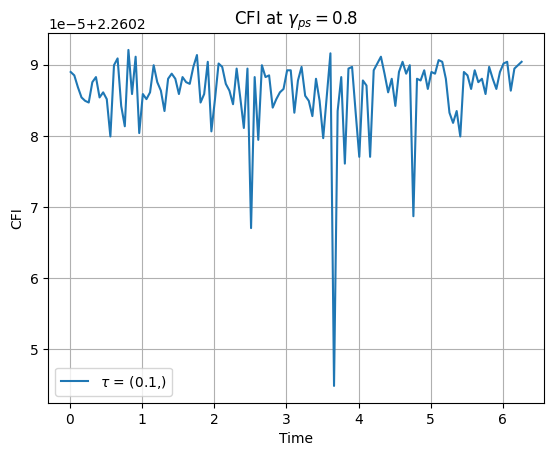

In [16]:
plt.plot(res[0][:,0], res[0][:,1], label = f'$\\tau$ = {tau_dephase}')
plt.title(f'CFI at $\gamma_{{ps}} = {gamma_ps}$')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()
plt.show()

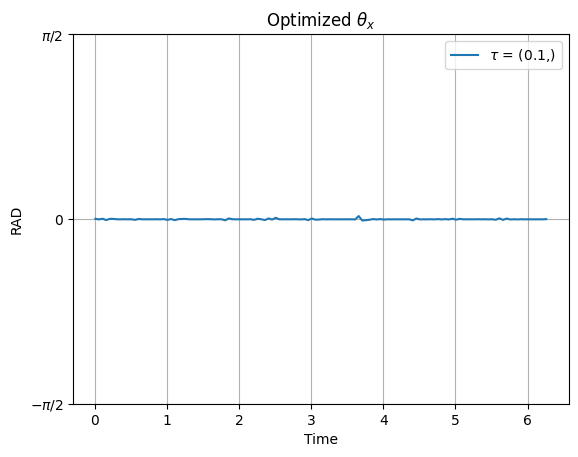

In [17]:
plt.plot(res[0][:,0], res[0][:,2], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

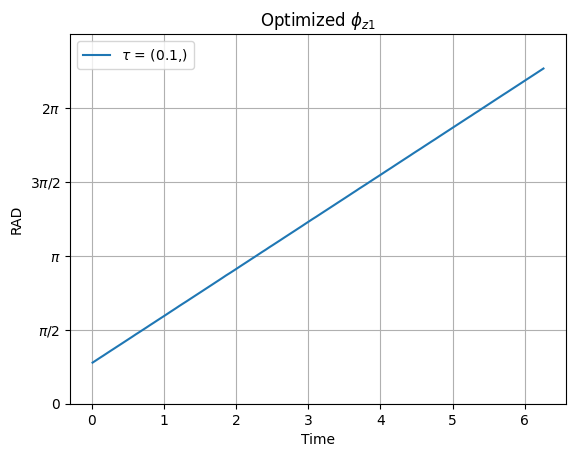

In [32]:
plt.plot(res[0][:,0], res[0][:,3], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, 5*np.pi/2)
plt.title(f'Optimized $\\phi_{{z1}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

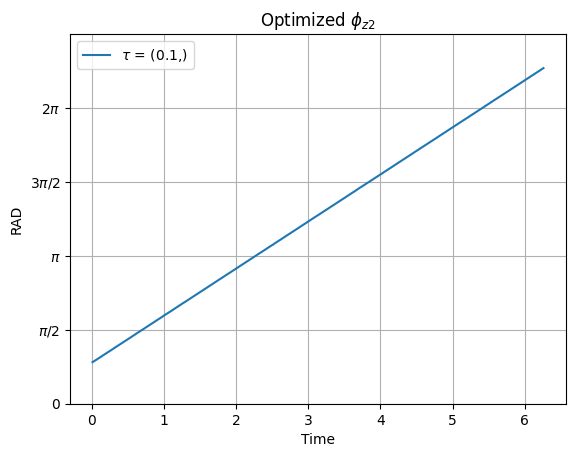

In [25]:
plt.plot(res[0][:,0], res[0][:,4], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, 5*np.pi/2)
plt.title(f'Optimized $\\phi_{{z2}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

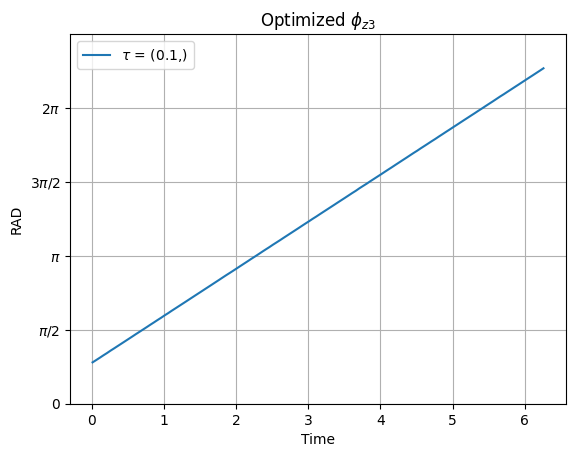

In [26]:
plt.plot(res[0][:,0], res[0][:,5], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, 5*np.pi/2)
plt.title(f'Optimized $\\phi_{{z3}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

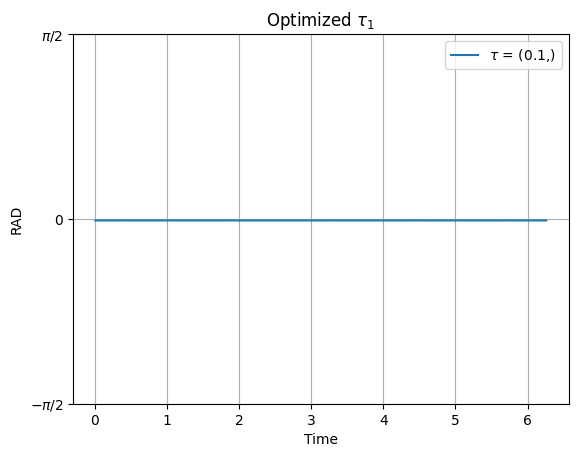

In [29]:
plt.plot(res[0][:,0], res[0][:,6], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\tau_{1}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

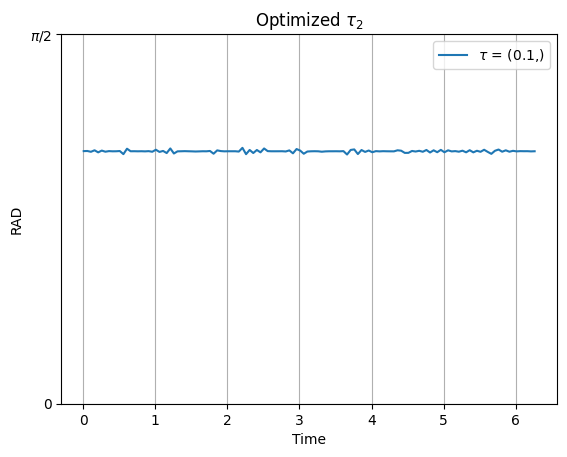

In [30]:
plt.plot(res[0][:,0], res[0][:,7], label = f'$\\tau$ = {tau_dephase}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, np.pi/2)
plt.title(f'Optimized $\\tau_{2}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()